In [1]:
from neck_correctify import load_img_and_ann
import matplotlib.pyplot as plt 
import math
import numpy as np
from geometry_tools import line_segments_offset
from PIL import Image

In [2]:
# 计算中点
def middle_point(p1,p2):
    return ( (p1[0] + p2[0]) /2 ,(p1[1] + p2[1]) /2   )

In [3]:
# 估算头部截取
# 肩部宽度作为 宽， 长为从 脸颊最下面点 到鼻子 长度的  两倍。
def get_head_mask(ann):
    left_shoulder = ann['left_shoulder'][0]
    right_shoulder = ann['right_shoulder'][0]
    nose = ann['nose'][0]
    chi = ann['chi']
    chi_points = sorted(chi ,key= lambda x : x[0])
    
    lowest_chi = chi_points[5] # 下巴点
    mid_p = middle_point( left_shoulder, right_shoulder  )
        
    
    width =  abs( left_shoulder[0] -  right_shoulder[0] )
    height = 2* abs( nose[1] - mid_p[1]  )
    
    delta = 5
    left_upper  = [ mid_p[0] - width/2,   max(lowest_chi[1] + delta - height , 0) ] 
    right_bottom = [ left_upper[0] + width , lowest_chi[1] + delta ] 
    
    return [ math.floor(left_upper[0]) , math.floor(left_upper[1] ), math.floor(right_bottom[0] ), math.floor(right_bottom[1])]

In [4]:
folder = "./测试素材/测试人物/"
ann_folder = load_img_and_ann(folder)

ann_source = ann_folder['4 (2)'][1]
head_source = get_head_mask(ann_source)
img_source = ann_folder['4 (2)'][0]

img_target = ann_folder['4 (3)'][0]
ann_target = ann_folder['4 (3)'][1]
head_target = get_head_mask(ann_target)

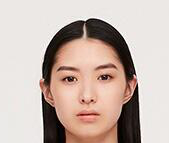

In [5]:
img_source.crop(head_source)


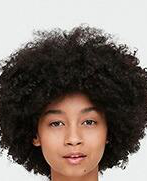

In [6]:
img_target.crop(head_target)

In [7]:
Q = ann_target['chi'] # target points 
P = ann_source['chi'] # source position points 

In [8]:
#  T :  [radians , tx , ty ]
def cost_func_isometric_translate(T ):
    cost = 0.0
    ksi = 1 
    radians = T[0]
    tx = T[1]
    ty = T[2]
    
    TM =  np.array( [ [ ksi* math.cos(radians), -math.sin(radians), tx ] , [ ksi*math.sin(radians) , math.cos(radians) ,ty  ] , [0, 0, 1]   ]  )
   # P_t_all = []
    for i in range(11):
        P_t = np.matmul(TM , np.array( [ P[i][0],P[i][1] ,1 ]).T) # note : homogeneus coordinate
       # P_t_all.append(P_t)
        cost +=  (P_t[0] - Q[i][0]) ** 2  + ( P_t[1] - Q[i][1]) ** 2 
    return cost

In [9]:

# 定义 Isometries 变换 （等距变换）
ksi = 1 
theta0 = 15 *math.pi / 180
tx0 = 10
ty0 = 10 
para_iso = [theta0 , tx0 , ty0]

#求极值
from scipy.optimize import minimize

res = minimize(cost_func_isometric_translate, para_iso, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
print(res.success)
print(res.x)

Optimization terminated successfully.
         Current function value: 5648.116137
         Iterations: 171
         Function evaluations: 333
True
[-0.09122301 -1.05167162 85.9192686 ]


In [10]:
# 3*3 matrix image transform
# img : nd-array 
# coordinate transform : https://towardsdatascience.com/image-geometric-transformation-in-numpy-and-opencv-936f5cd1d315
def image_transform(img: np.ndarray, T):
    height, width = img.shape[0:2]
    x_cor, y_cor = np.meshgrid(range(width), range(height))
    x_r = x_cor.flatten().reshape((1, height * width))
    y_r = y_cor.flatten().reshape((1, height * width))
    c_mat = np.vstack( (x_r, y_r, np.ones_like(x_r) )).astype(np.float32)

    transformed_coordiantes = np.matmul(T, c_mat)
    transformed_coordiantes = np.floor(transformed_coordiantes).astype(np.int)
    x_trans = transformed_coordiantes[0, :]
    y_trans = transformed_coordiantes[1, :]

    indices = np.where((x_trans >= 0) & (x_trans < width) & (y_trans >= 0) &
                       (y_trans < height))
    x_trans = x_trans[indices]
    y_trans = y_trans[indices]

    x_r = x_r.flatten()[indices]
    y_r = y_r.flatten()[indices]

    # Map the pixel RGB data to new location in another array
    canvas = np.zeros_like(img , dtype= img.dtype)
    canvas[y_trans, x_trans, :] = img[y_r, x_r, :]
    return canvas                   

In [11]:
T = res.x
ksi = 1 
radians = T[0]
tx = T[1]
ty = T[2]
TM =  np.array( [ [ ksi* math.cos(radians), -math.sin(radians), tx ] , [ ksi*math.sin(radians) , math.cos(radians) ,ty  ] , [0, 0, 1]   ]  )

In [14]:
source_image_mask = np.zeros(shape = img_source.size +(3,) , dtype = np.uint8 )
source_image_mask = Image.fromarray(source_image_mask)
source_image_mask.paste(img_source.crop(head_source)  ,box = head_source )

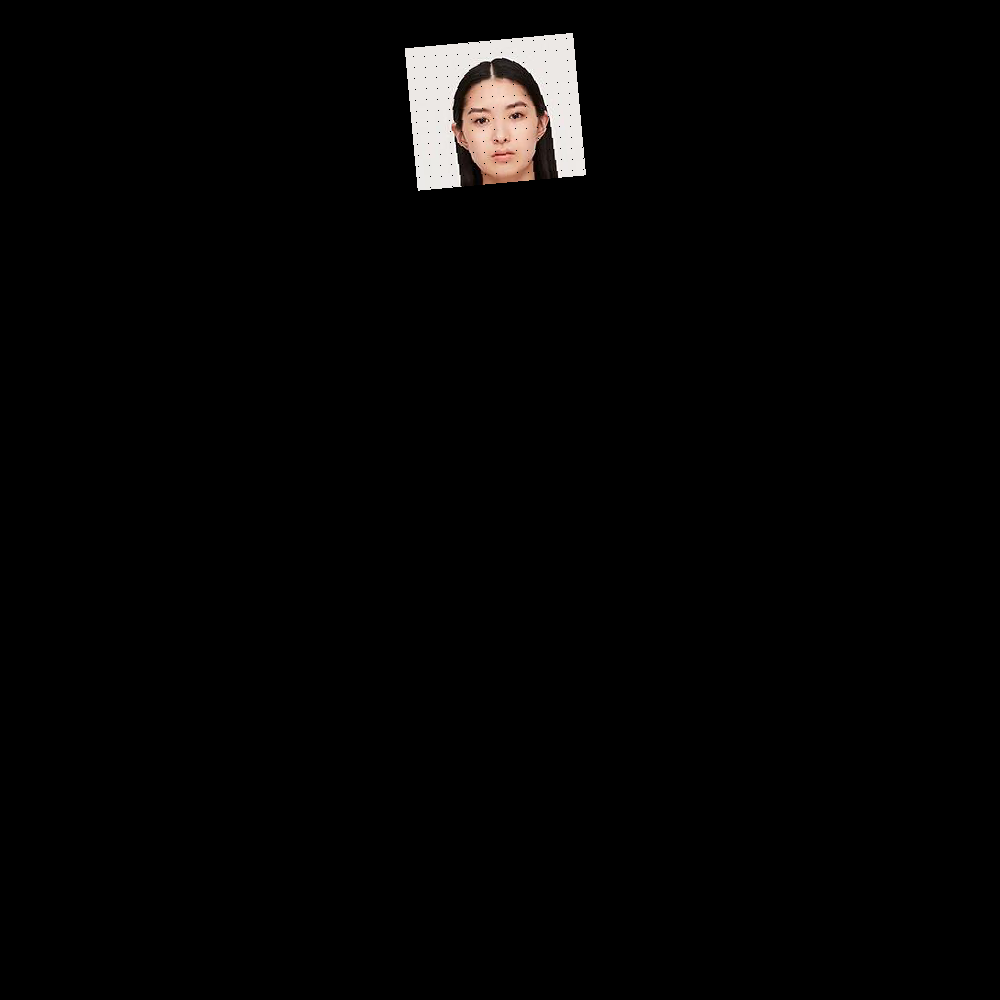

In [17]:
source_img_warp = image_transform(np.array(source_image_mask), TM)
Image.fromarray(source_img_warp)

In [31]:
target_image_mask = img_target.copy()
target_image_mask.paste(0, head_target)

syn_img = np.where(source_img_warp , source_img_warp , np.array(target_image_mask) )


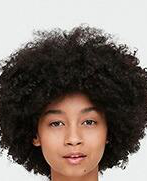

In [35]:
img_target.crop(head_target)

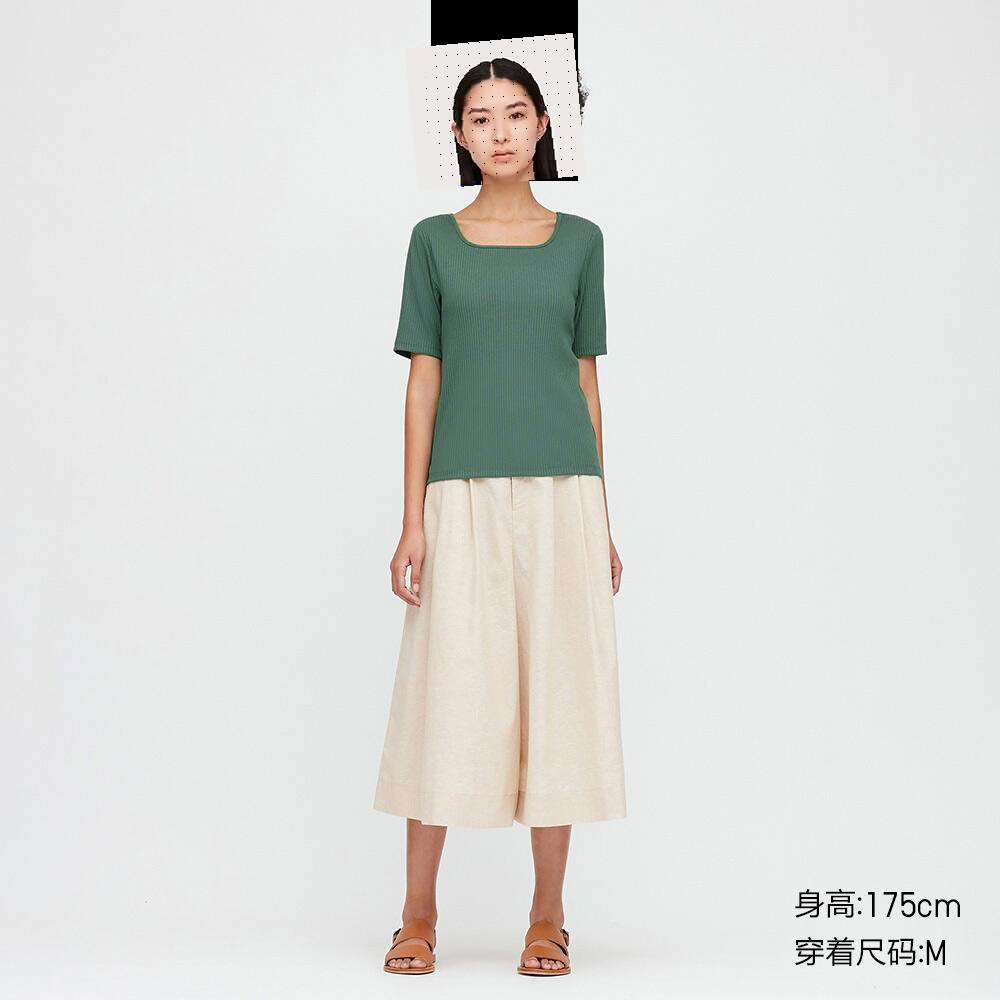

In [32]:
# 改进  ：1. 预估的一个旋转变换， 模特头部不能歪，需要通过其它方法来实现。2. 脖子歪了，显然不适合下一步融合。 

Image.fromarray(syn_img)